We will be building on top of [this notebook](https://github.com/dipanjanS/adversarial-learning-robustness/blob/main/tutorials/attacks/01_1_simple_pgd.ipynb). We will learn how to launch a simple PGD-based attack on [EfficientNet](https://arxiv.org/pdf/1905.11946) and its [Noisy Student (NST)](https://arxiv.org/abs/1911.04252) variant. It will be clear that under the same hyperparameter configurations, they perform better than other networks like ResNet50. 

Noisy Student Training doesn't incorporate any explicit adversarial training objective. It incorporates the following elements during the student training that help to bring the robustness in the learned representations - 
* Strong augmentation (augmentations as used in [RandAugment](https://arxiv.org/abs/1909.13719))
* [Stochastic Depth](https://arxiv.org/abs/1603.09382)
* Dropout

The following figure makes it clear that Noisy Student Trained EfficientNet performs better under adversarial perturbations (FGSM) than the vanilla EfficientNet - 

<center>
<img src="https://i.ibb.co/qySCcWV/image.png" width=500></img><br>
<small>Source: <a href="https://arxiv.org/abs/1911.04252">Self-training with Noisy Student improves ImageNet classification></a></small>
</center>

**Note**: EfficientNet models in `tf.keras.applications` take care of normalization as a part of in-model preprocessing. So, we don't need to apply any pixel scaling beforehand. 

## Initial setup and imports

In [ ]:
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications.resnet50 import decode_predictions
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import json
import cv2

print("TensorFlow version: ",tf.__version__)

TensorFlow version:  2.3.0


We first download a sample image which we will perturb in order to fool our pre-trained image classifier. We also download a dictionary that contains the mapping between the Imagenet dataset class labels and their ids.

In [ ]:
!wget -q https://adversarial-ml-tutorial.org/introduction/pig.jpg
!wget -q https://raw.githubusercontent.com/USCDataScience/dl4j-kerasimport-examples/master/dl4j-import-example/data/imagenet_class_index.json

## A few early constants

In [ ]:
EPS = 2./255
IMAGENET_LABELS = "imagenet_class_index.json"

with open(IMAGENET_LABELS) as f:
    IMAGENET_CLASSES = {int(i):x[1] for i,x in json.load(f).items()}

## Utility functions

Next we define a couple of utility functions that we will be using throughout the course of this notebook.

In [ ]:
# Function to load up an image from a local filepath and
# display it
def show_image(image_path):
    image_pixels = plt.imread(image_path)
    plt.imshow(image_pixels)
    plt.show()
    return image_pixels

# Function to preprocess an image for performing inference
def preprocess_image(image_pixels):
    image_pixels = cv2.resize(image_pixels, (224, 224))
    image_pixels = np.expand_dims(image_pixels, axis=0)
    return image_pixels

# Clipping utility to project delta back to our favorable pixel
# range ([0 ,1])
def clip_eps(delta_tensor):
    return tf.clip_by_value(delta_tensor, 
                            clip_value_min=-EPS, 
                            clip_value_max=EPS)

# Parse the label
def get_label(preds):
    print(IMAGENET_CLASSES[preds.argmax()])

## Downloading the noisy student training weights and preparing them

In [ ]:
!wget -q https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/noisystudent/noisy_student_efficientnet-b0.tar.gz
!tar -xf noisy_student_efficientnet-b0.tar.gz

!wget -q https://raw.githubusercontent.com/yixingfu/tensorflow/updateweights/tensorflow/python/keras/applications/efficientnet_weight_update_util.py
!python efficientnet_weight_update_util.py --model b0 --ckpt \
       noisy_student_efficientnet-b0/model.ckpt --o efficientnetb0.h5

2020-10-23 16:17:51.614648: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-10-23 16:17:53.310973: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-10-23 16:17:53.367005: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2020-10-23 16:17:53.367062: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (37a642413e36): /proc/driver/nvidia/version does not exist
2020-10-23 16:17:53.397135: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2300000000 Hz
2020-10-23 16:17:53.397394: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1850a00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-10-23 16:17:53.397429: I tensorflow/com

## Loading our first image and pre-trained models

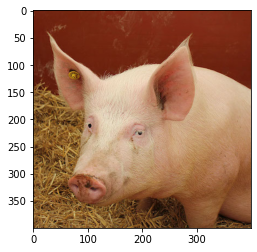

In [ ]:
sample_image = show_image("pig.jpg")
preprocessed_image = preprocess_image(sample_image)
enb0 = tf.keras.applications.EfficientNetB0(weights="imagenet")
enb0_nst = tf.keras.applications.EfficientNetB0(weights="efficientnetb0.h5")

## Running inference with the pre-trained models

In [ ]:
# Run inference EfficientNetB0 (ImageNet)
preds = enb0.predict(preprocessed_image)
print("Predicted:", decode_predictions(preds, top=3)[0])
print("Class idx:", preds.argmax())

40960/35363 [==================================] - 0s 0us/step
Predicted: [('n02395406', 'hog', 0.95161813), ('n02396427', 'wild_boar', 0.008885965), ('n03935335', 'piggy_bank', 0.00097579224)]
Class idx: 341


In [ ]:
# Run inference EfficientNetB0 (NST)
preds = enb0_nst.predict(preprocessed_image)
print("Predicted:", decode_predictions(preds, top=3)[0])
print("Class idx:", preds.argmax())

Predicted: [('n02395406', 'hog', 0.9592692), ('n02396427', 'wild_boar', 0.011101276), ('n03935335', 'piggy_bank', 0.00037483746)]
Class idx: 341


## Utility functions for adversarial attacks

In [ ]:
def generate_adversaries(image_tensor, delta, model,
    true_index):
    # Loss and optimizer
    scc_loss = tf.keras.losses.SparseCategoricalCrossentropy()
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-3)

    for t in range(350):
        plt.show()
        with tf.GradientTape() as tape:
            tape.watch(delta)
            inp = image_tensor + delta
            predictions = model(inp, training=False)
            loss = - scc_loss(tf.convert_to_tensor([true_index]), predictions) 
            if t % 20 == 0:
                print(t, loss.numpy())
            
        # Get the gradients
        gradients = tape.gradient(loss, delta)
        
        # Update the weights
        optimizer.apply_gradients([(gradients, delta)])

        # Project the delta back (l-infinite norm)
        delta.assign_add(clip_eps(delta))

    return delta

def perturb_image(image_path, true, model):
    # Load and preprocess image but a but without any `preprocess_input`
    sample_image = show_image(image_path)
    preprocessed_image = preprocess_image(sample_image)

    # Generate predictions before any adversaries
    unsafe_preds = model.predict(preprocessed_image)
    print("Prediction before adv.:", decode_predictions(unsafe_preds, top=3)[0])

    # Initialize the perturbation quantity
    image_tensor = tf.constant(preprocessed_image, dtype=tf.float32)
    delta = tf.Variable(tf.zeros_like(image_tensor), trainable=True)

    # Get the learned delta and display it
    delta_tensor = generate_adversaries(image_tensor, delta, model, true)
    plt.imshow(50*delta_tensor.numpy().squeeze()+0.5)
    plt.show()

    # See if the image changes
    plt.imshow((image_tensor + delta_tensor).numpy().squeeze()/255)
    plt.show()

    # Generate prediction
    perturbed_image = image_tensor + delta_tensor
    preds = model.predict(perturbed_image)
    print("Prediction after adv.:", decode_predictions(preds, top=3)[0])

Note that the hyperparameters like learning rate, number of epochs were determined after empirical experiments and also by referring to [this tremendous tutorial](https://adversarial-ml-tutorial.org/introduction/).

## Launching a simple attack!

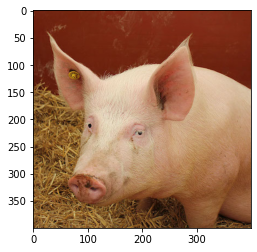

Prediction before adv.: [('n02395406', 'hog', 0.95161813), ('n02396427', 'wild_boar', 0.008885965), ('n03935335', 'piggy_bank', 0.00097579224)]
0 -0.049591452
20 -0.12711588
40 -0.31343994
60 -0.65371037
80 -1.136956
100 -1.7124175
120 -2.3249261
140 -2.9327667
160 -3.510994
180 -4.051402
200 -4.55844
220 -5.0439906
240 -5.52576
260 -6.02678
280 -6.575241
300 -7.2011538
320 -7.9124317
340 -8.66891


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


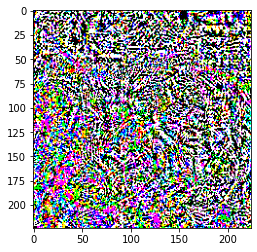

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


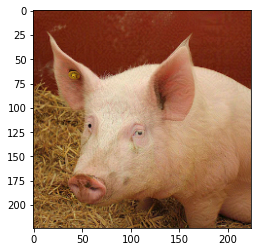

Prediction after adv.: [('n02328150', 'Angora', 0.2657735), ('n02342885', 'hamster', 0.14995982), ('n02364673', 'guinea_pig', 0.02965677)]


In [ ]:
# With Efficient + ImageNet pre-trained weights
perturb_image("pig.jpg", 341, enb0)

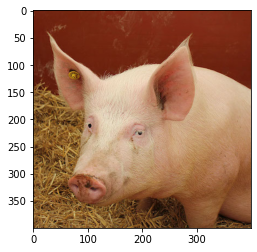

Prediction before adv.: [('n02395406', 'hog', 0.9592692), ('n02396427', 'wild_boar', 0.011101276), ('n03935335', 'piggy_bank', 0.00037483746)]
0 -0.041583728
20 -0.11357538
40 -0.268446
60 -0.5370593
80 -0.93314636
100 -1.4082248
120 -1.8956629
140 -2.3567944
160 -2.783148
180 -3.1789925
200 -3.547484
220 -3.893741
240 -4.229043
260 -4.558997
280 -4.84649
300 -5.064619
320 -5.2517066
340 -5.4176946


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


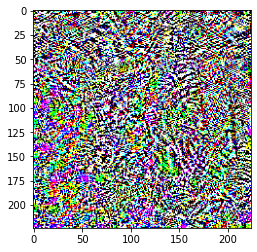

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


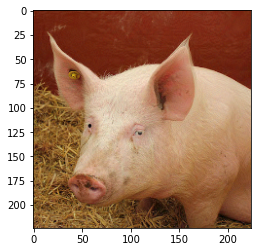

Prediction after adv.: [('n02395406', 'hog', 0.0041087028), ('n02397096', 'warthog', 0.0031802289), ('n02910353', 'buckle', 0.0025838162)]


In [ ]:
# With Efficient + Noisy Student Training weights
perturb_image("pig.jpg", 341, enb0_nst)

We see that under similar hyperparameter configurations, it's harder to fool EfficientNet variants. 